In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
import shapely.geometry as shpg
import cv2
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)

In [2]:
ext_array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_ext_0.npy')
int_array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_int_0.npy')
# ext_array = ext_array[:-1]
# int_array = int_array[:-1]

In [3]:
def offset_surface(ext_line, offset):
    '''
    Create artificial internal surface based on an offset
    Don't implement in main script it's just for testing
    '''
    # Create a Polygon from the 2d array
    poly = shpg.Polygon(ext_line)

    # Create offset in inward direction
    noffpoly = poly.buffer(offset)  # offset

    # Turn polygon points into numpy arrays for plotting
    afpolypts = np.array(poly.exterior)
    noffafpolypts = np.array(noffpoly.exterior)
    return noffafpolypts

/tmp/ipykernel_52226/631566807.py:5: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ext_offset = offset_surface(ext_array, -offset)


(100, 2)
(100, 2)


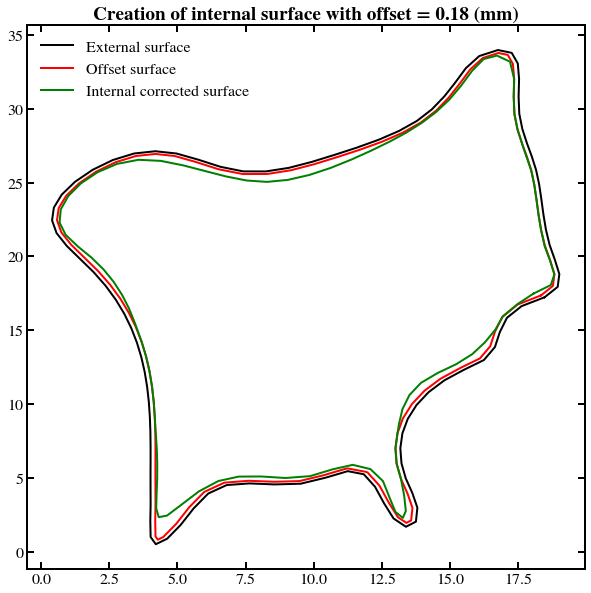

In [8]:
# TEST IF POINT INSIDE POLYGON
# https://stackoverflow.com/questions/50670326/how-to-check-if-point-is-placed-inside-contour
plt.style.use('simone')
offset = 180e-3
ext_offset = offset_surface(ext_array, -offset)

is_inside = [shpg.Point(int_array[i]).within(shpg.Polygon(ext_offset)) for i in range(len(int_array))]
is_inside = np.c_[is_inside, is_inside]
closest_points = [ext_offset[spatial.KDTree(ext_offset).query(int_array[i])[1]] for i in range(len(int_array))]
closest_points = np.array(closest_points).reshape(-1, 2)
print(int_array.shape)
print(closest_points.shape)

np.copyto(dst=int_array, src=closest_points, where=np.logical_not(is_inside))

plt.figure(figsize=(10, 10))
plt.title(f'Creation of internal surface with offset = {offset} (mm)', weight='bold')
plt.plot(ext_array[:, 0], ext_array[:, 1], 'k', label='External surface')
plt.plot(ext_offset[:, 0], ext_offset[:, 1], 'r', label='Offset surface')
plt.plot(int_array[:, 0], int_array[:, 1], 'g', label='Internal corrected surface')
plt.legend()
plt.savefig('/home/simoneponcioni/Desktop/meeting_221125/offset_correction.png', dpi=300)

In [ ]:
import matplotlib
print(matplotlib.style.available)

In [ ]:

def correct_internal_point(arr, idx, dx, dy):
    """
    Corrects [x, y] position of points of internal array
    Args:
        arr (ndarray): array of internal perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness
    Returns:
        ndarray: new position of internal points in array 'arr'
    """
    return np.array([arr[idx][:, 0] - dy, arr[idx][:, 1] + dx]).transpose()

def correct_intersection(ext_arr, int_arr, pairs, dx, dy, bool_arr):
    """
    Takes ext and int arrays and applies nodal displacement to the elements where bool_min_thickness == True
    Args:
        ext_arr (ndarray): array of [x, y] external points composing the perimeter
        int_arr (ndarray): array of [x, y] internal points composing the perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness
        bool_min_thickness (list): list indicating where the thickness is below tolerance
    Returns:
        ndarray: new array of internal polygon
    """
    bool_arr = np.c_[bool_arr, bool_arr]
    int_corr = correct_internal_point(ext_arr, pairs[0], dx, dy)
    np.copyto(dst=int_arr[pairs[1]], src=int_corr, where=bool_arr)
    return int_arr


def KD_2_Tree(arr1, arr2, ext_offset):
    """
    Find nearest point between two arrays and create a an array containing nearest-pairs indices
    
    Args:
        arr1 (np.ndarray): array of contour 1
        arr2 (np.ndarray): array of contour 2
        
    Returns:
        _type_: _description_
    """
    corr_int = np.empty((len(arr1), 2), dtype=float)
    for i, idx in enumerate(arr1):
        d_nn_ext_int, closest_idx_ext_int = spatial.KDTree(arr2).query(idx)
        d_nn_ext_offs, closest_idx_ext_offs = spatial.KDTree(ext_offset).query(idx)       
        
        if d_nn_ext_int > d_nn_ext_offs:
            corr_int[i] = arr2[closest_idx_ext_int]
        elif d_nn_ext_int < d_nn_ext_offs:
            corr_int[i] = ext_offset[closest_idx_ext_offs]
    return corr_int


ext_offset = offset_surface(ext_array, -0.1)
corr_int = KD_2_Tree(ext_array, int_array, ext_offset)
plt.plot(corr_int[:, 0], corr_int[:, 1], 'o', color='red')

In [ ]:
#### Find intersections between points at [0°, 90°, 180°, 270°] and contour

In [ ]:
import shapely.geometry as shpg
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt


def centeroidnp(arr):
    length, dim = arr.shape
    return np.array([np.sum(arr[:, i])/length for i in range(dim)])


def shapely_line_polygon_intersection(poly, line_1):
    """
    Find the intersection point between two lines
    Args:
        line1 (shapely.geometry.LineString): line 1
        line2 (shapely.geometry.LineString): line 2
    Returns:
        shapely.geometry.Point: intersection point
    """
    shapely_poly = shpg.Polygon(poly)
    shapely_line = shpg.LineString(line_1)
    return list(shapely_poly.intersection(shapely_line).coords)


def partition_lines(radius, center_of_mass):
    points = np.linspace(0, 2*np.pi, 4, endpoint=False)
    points_on_circle = np.array([center_of_mass[0] + radius * np.cos(points), center_of_mass[1] + radius * np.sin(points)]).transpose()
    line_1 = np.array([points_on_circle[0], points_on_circle[2]])
    line_2 = np.array([points_on_circle[1], points_on_circle[3]])
    return line_1, line_2


def intersection_point(arr, intersection_1):
    """
    Insert intersection point between two lines in the array
    Args:
        arr (ndarray): array of points
        intersection_1 (ndarray): intersection point 1
        intersection_2 (ndarray): intersection point 2
    Returns:
        ndarray: new array with intersection points
    """
    _, closest_idx = spatial.KDTree(arr).query(intersection_1)
    print(f'closest index where to insert the intersection point: {closest_idx}')
    return closest_idx


def insert_closest_point(arr, closest_idx, values):
    """
    Insert intersection point between two lines in the array
    Args:
        arr (ndarray): array of points
        closest_idx (ndarray): index of the closest point
    Returns:
        ndarray: new array with intersection points
    """
    arr[closest_idx] = values
    return arr


array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_int_8.npy')
center_of_mass_xy = centeroidnp(array)
intersection_1= shapely_line_polygon_intersection(array, partition_lines(50, center_of_mass_xy)[0])
intersection_2 = shapely_line_polygon_intersection(array, partition_lines(50, center_of_mass_xy)[1])
intersections = np.array([intersection_1, intersection_2])
closest_ind = np.empty((len(intersections), 1), dtype=int)

print(len(array))
for _, intersection in enumerate(intersections):
    for i, inters in enumerate(intersection):
        print(f'intersection point {i}: {inters}')
        closest_idx = intersection_point(array, inters)
        array = insert_closest_point(array, closest_idx, inters)

fig2 = plt.figure(figsize=(10, 10))
plt.scatter(array[:, 0], array[:, 1], color='black')
# plt.xlim(14, 17)
# plt.ylim(15, 18)
for i, txt in enumerate(range(len(array))):
    plt.annotate(txt, (array[i, 0], array[i, 1]), color="tab:blue")

array[-1] = array[0]
# np.save('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_int_11_point_insertion.npy', array)

In [ ]:
import math
# box diagonals
x_cog, y_cog = centeroidnp(array)
print(f'Cog of the cube (x, y): {x_cog, y_cog}')

edge_length = 4.5
half_diag = (math.sqrt(2) * edge_length) / 2
lx_min, lx_max = x_cog - half_diag, x_cog + half_diag
ly_min, ly_max = y_cog - half_diag, y_cog + half_diag
print(f'lx_min, lx_max: {lx_min, lx_max}')
print(f'ly_min, ly_max: {ly_min, ly_max}')
